# Part 1

We begin by importing the packages we will need:

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
print('TF version:', tf.__version__)

TF version: 2.1.0


Before moving onto the 2-D Gaussian profile:

In [3]:
X, Y = np.mgrid[-4:4:10**-2, -4:4:10**-2]

xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))

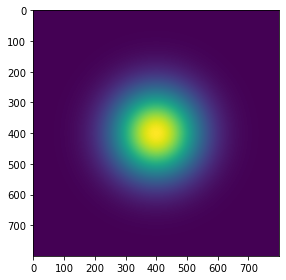

In [4]:
zs_gauss = tf.exp(-(xs**2 + ys**2)/2)

plt.imshow(zs_gauss.numpy())
plt.tight_layout()
plt.show()

And a 2-D periodic profile:

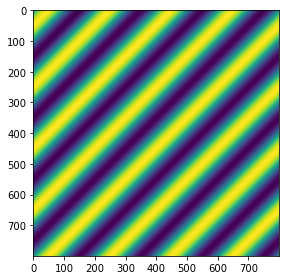

In [5]:
zs_sin = tf.sin(np.pi*(xs+ys))

plt.imshow(zs_sin.numpy())
plt.tight_layout()
plt.show()

And their product:

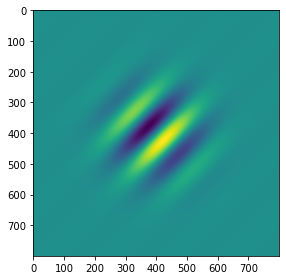

In [6]:
zs_prod = zs_gauss*zs_sin

plt.imshow(zs_prod.numpy())
plt.tight_layout()
plt.show()

# Part 2

The following functions will help us explore the Mandelbrot set.

In [20]:
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

In [44]:
def showFractal(X, Y):
    Z = X + 1j*Y
    
    xs = tf.constant(Z.astype(np.complex64))
    zs = tf.Variable(xs)
    ns = tf.Variable(tf.zeros_like(xs, tf.float32))

    for i in range(200):
        #Compute the new values of z: z^2 + x
        zs_ = zs*zs + xs
        # Have we diverged with this new value?
        not_diverged = tf.abs(zs_) < 5
        # Update variables to compute
        ns.assign_add(tf.cast(not_diverged, tf.float32))
        zs.assign(zs_)

    fig = plt.figure(figsize=(16,10))

    plt.imshow(processFractal(ns.numpy()))
    plt.tight_layout(pad=0)
    plt.show()

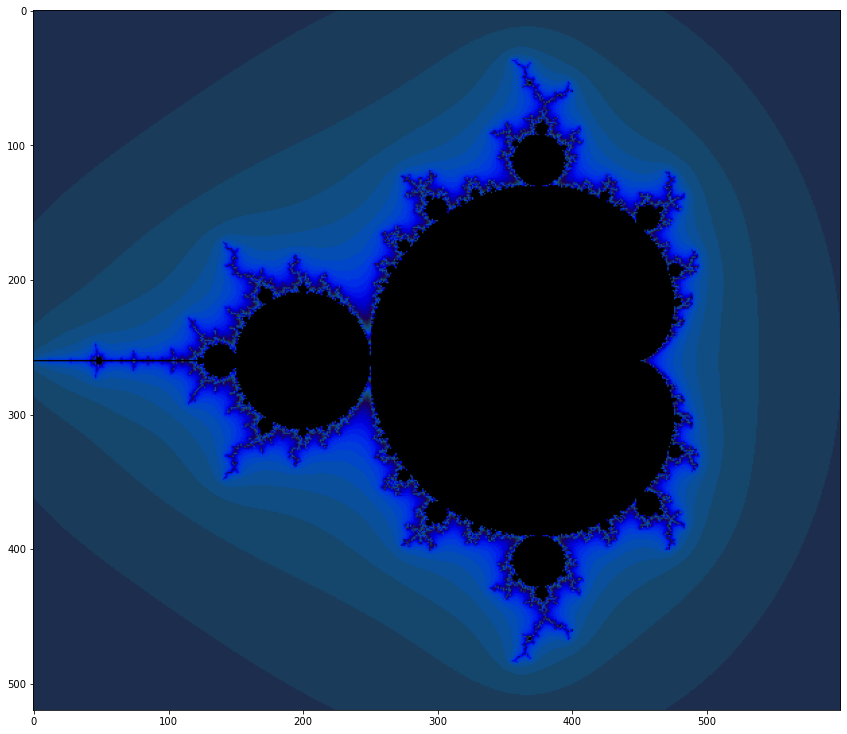

In [22]:
Y , X = np.mgrid [-1.3:1.3:0.005 , -2:1:0.005]

showFractal(X, Y)

We can rerun this with decreased grid spacing ($5 \times 10^{-3} \rightarrow 5 \times 10^{-4}$) to generate a higher quality image, noting that at a spacing of $10^{-4}$ we need to begin allocating memory more carefully.

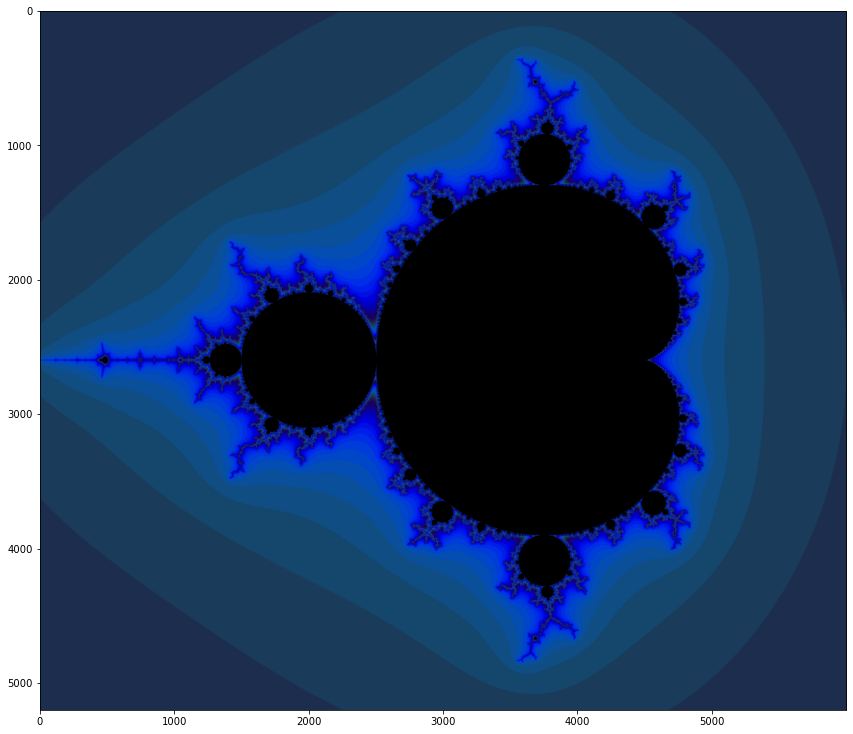

In [23]:
Y , X = np.mgrid [-1.3:1.3:0.0005 , -2:1:0.0005]

showFractal(X, Y)

Things look pretty well the same, indicating the initial spacing was sufficient. Compare this to the case where we increase the grid spacing ($5 \times 10^{-3} \rightarrow 5 \times 10^{-2}$. Note that we could better blend the outer blue equi-divergences of the previous figure by changing to a finely grained contour plot instead.

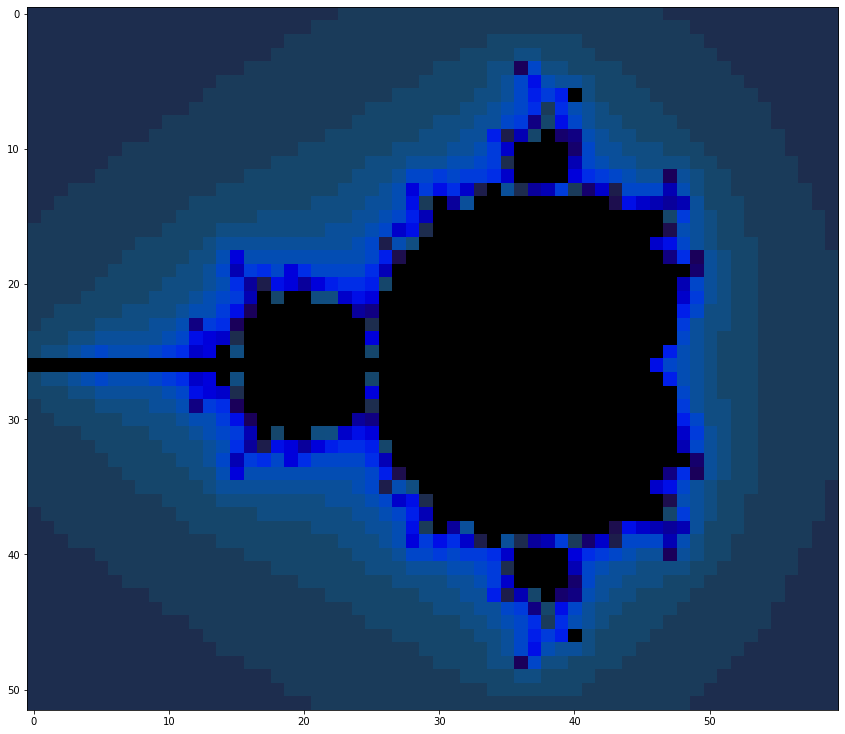

In [24]:
Y , X = np.mgrid [-1.3:1.3:0.05 , -2:1:0.05]

showFractal(X, Y)

Returning to the original resolutions, let's zoom in to one of the arms at around 10 o'clock.

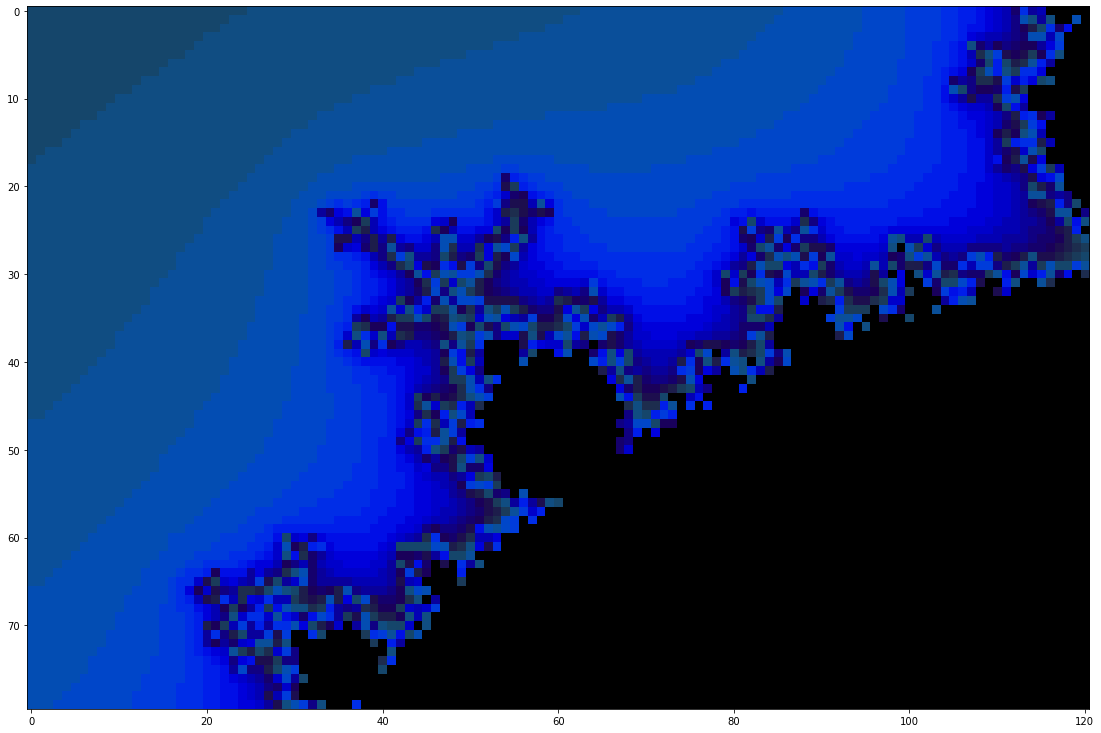

In [35]:
Y , X = np.mgrid [-.8:-.4:0.005 , -.8:-.2:0.005]

showFractal(X, Y)

Here we can see the differences in resolution ($5 \times 10^{-3} \rightarrow 5 \times 10^{-4}$).

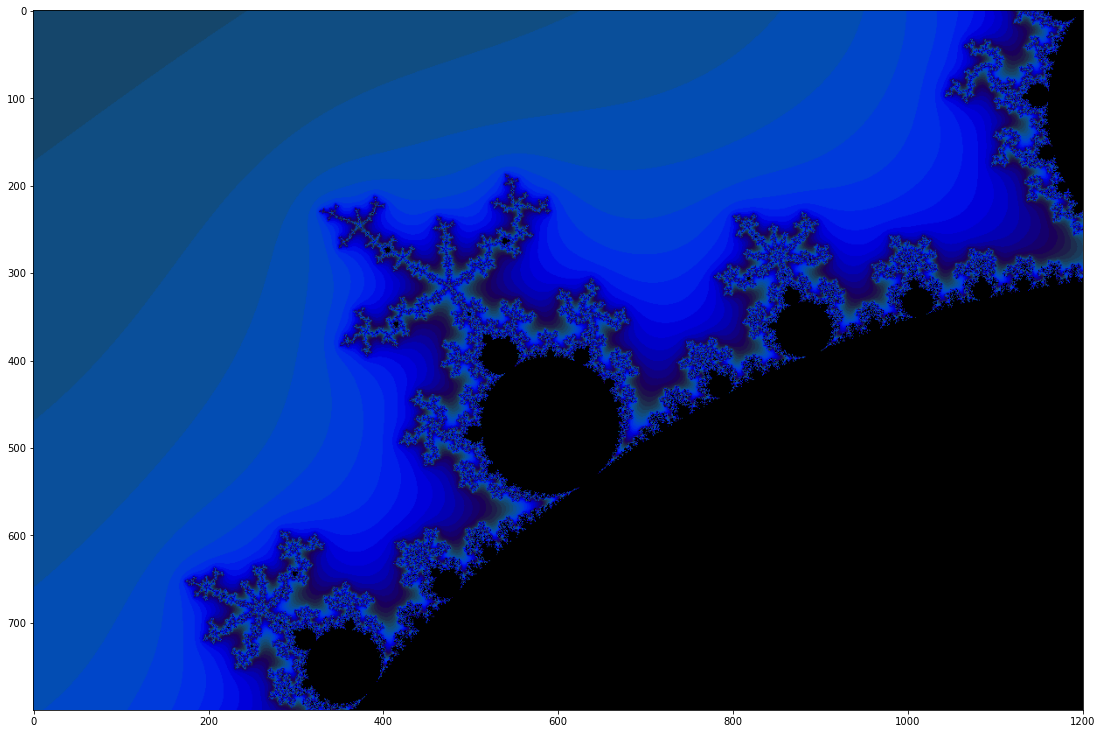

In [45]:
Y , X = np.mgrid [-.8:-.4:0.0005 , -.8:-.2:0.0005]

showFractal(X, Y)

Finally we can update ```processFractal``` and ```showFractal``` to display the Julia set, in which we still iterate via $z_{n+1} = z_n^2 + c$ but begin with a fixed value of $c$ and each point at $z_0$. This is in contrast to the Mandelbrot set which takes each point as $c$ and begins with $z=0$. As such the Mandelbrot set can be thought of as displaying the origin of every possible Julia set. Here we consider the Julia set at $c = -.79 + .15i$.

In [36]:
def showFractal(X, Y):
    Z = X + 1j*Y
    
    xs = tf.constant(Z.astype(np.complex64))
    zs = tf.Variable(xs)
    ns = tf.Variable(tf.zeros_like(xs, tf.float32))

    for i in range(200):
        #Compute the new values of z: z^2 + x
        zs_ = zs*zs - .79 + .15j
        # Have we diverged with this new value?
        not_diverged = tf.abs(zs_) < 5
        # Update variables to compute
        ns.assign_add(tf.cast(not_diverged, tf.float32))
        zs.assign(zs_)

    fig = plt.figure(figsize=(16,10))

    plt.imshow(processFractal(ns.numpy()))
    plt.tight_layout(pad=0)
    plt.show()

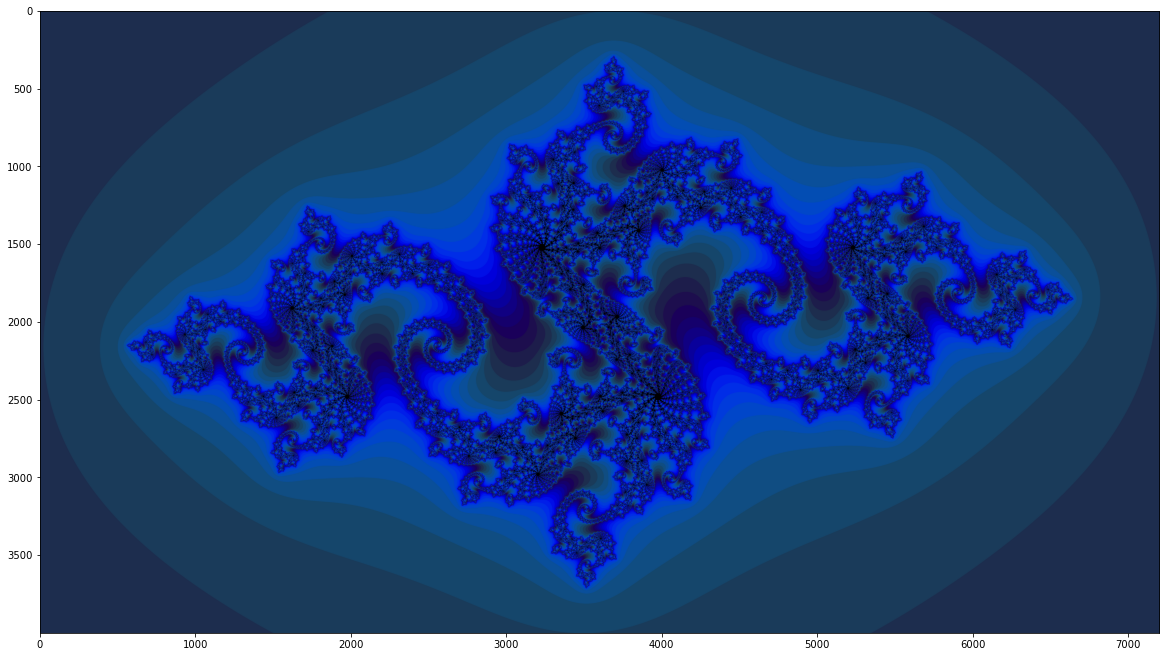

In [41]:
Y , X = np.mgrid [-1:1:0.0005 , -1.8:1.8:0.0005]

showFractal(X, Y)

# Part 3

Here we will model the Ikeda map, an abstracted model of the electric field of a wave in a specific optical ring resonator described at https://doi.org/10.1016/0030-4018(79)90090-7. First we try in ```numpy```.

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
def ikeda(u, P, N):
    xs = (np.random.rand(P) - .5)*15
    ys = (np.random.rand(P) - .5)*12 + 2

    fig, ax = plt.subplots(figsize=(8, 6))

    def compute_trajectory(u, x, y, N):
        X = np.zeros([N, 2])
        X[0, :] = [x, y]

        for n in range(1, N):
            t = 0.4 - 6/(1 + x**2 + y**2)
            x1 = 1 + u*(x*np.cos(t) - y*np.sin(t))
            y1 = u*(x*np.sin(t) + y*np.cos(t))
            x = x1
            y = y1

            X[n, :] = [x, y]

        return X

    def plot_trajectory(X):
        ax.plot(X[:, 0], X[:,1], 'w', alpha=.01)

    for p in range(P):
        X = compute_trajectory(u, xs[p], ys[p], N)

        plot_trajectory(X)
        
    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    fig.show()

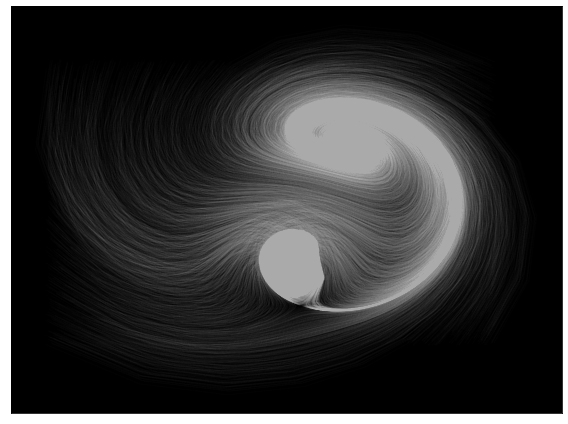

In [117]:
ikeda(.918, 10**4, 10**2)

And in ```tensorflow```:

In [120]:
def ikeda(u, P, N):
    xs = (tf.random.stateless_uniform([P], seed=(1, 2)) - .5)*15
    ys = (tf.random.stateless_uniform([P], seed=(2, 1)) - .5)*12 + 2

    fig, ax = plt.subplots(figsize=(8, 6))

    def compute_trajectory(u, x, y, N):
        X = tf.Variable(tf.zeros([N, 2]))
        X[0, :].assign([x, y])

        for n in range(1, N):
            t = 0.4 - 6/(1 + x**2 + y**2)
            x1 = 1 + u*(x*np.cos(t) - y*np.sin(t))
            y1 = u*(x*np.sin(t) + y*np.cos(t))
            x = x1
            y = y1

            X[n, :].assign([x, y])

        return X

    def plot_trajectory(X):
        ax.plot(X[:, 0], X[:,1], 'w', alpha=.1)

    for p in range(P):
        X = compute_trajectory(u, xs[p], ys[p], N)

        plot_trajectory(X.numpy())

    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    fig.show()

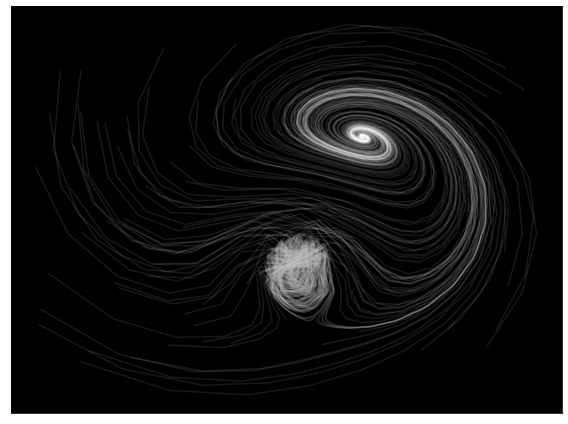

In [122]:
ikeda(.918, 10**2, 10**2)

The code is operational but much slower than in ```numpy``` due to ```tensorflow```'s reliance on vectorisation; accordingly we can only plot limited trajectories. We vectorise as below to increase the pace.

In [37]:
def ikeda(u, P, N):
    xs = (tf.random.stateless_uniform([P], seed=(1, 2)) - .5)*15
    ys = (tf.random.stateless_uniform([P], seed=(2, 1)) - .5)*12 + 2

    fig, ax = plt.subplots(figsize=(8, 6))

    def compute_trajectory(u, xs, ys, P, N):
        X = tf.Variable(tf.zeros([N, P]))
        Y = tf.Variable(X)
        X[0, :].assign(xs)
        Y[0, :].assign(ys)

        for n in range(1, N):
            t = 0.4 - 6/(1 + X[n-1, :]**2 + Y[n-1, :]**2)
            X[n, :].assign(1 + u*(X[n-1, :]*np.cos(t) - Y[n-1, :]*np.sin(t)))
            Y[n, :].assign(u*(X[n-1, :]*np.sin(t) + Y[n-1, :]*np.cos(t)))

        return X, Y

    def plot_trajectory(X, Y, p):
        ax.plot(X[:, p], Y[:, p], 'w', alpha=.1)

    for p in range(P):
        X, Y = compute_trajectory(u, xs, ys, P, N)
        plot_trajectory(X.numpy(), Y.numpy(), p)

    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    fig.show()

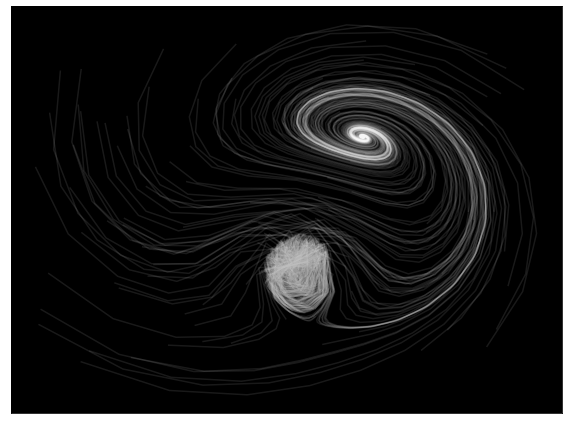

In [38]:
ikeda(.918, 10**2, 2*10**2)

Things are better but by no means good, perhaps suggesting that the parallelisation algorithms underlying ```tensorflow``` are sensitive primarily to tensor multiplication as in the back propagation of a neural network. Still, we explore some other $u$ values of the Ikeda map with our new function at the same resolution.

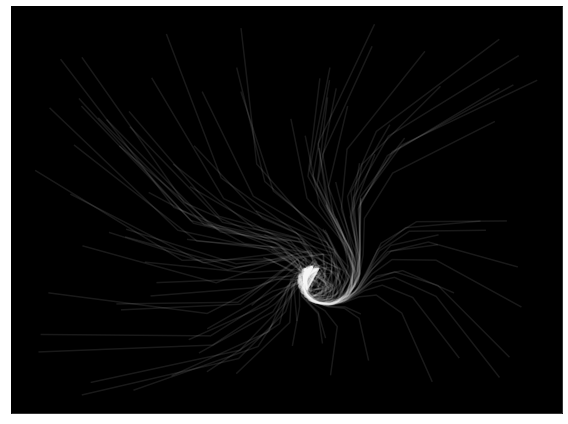

In [39]:
ikeda(.5, 10**2, 2*10**2)

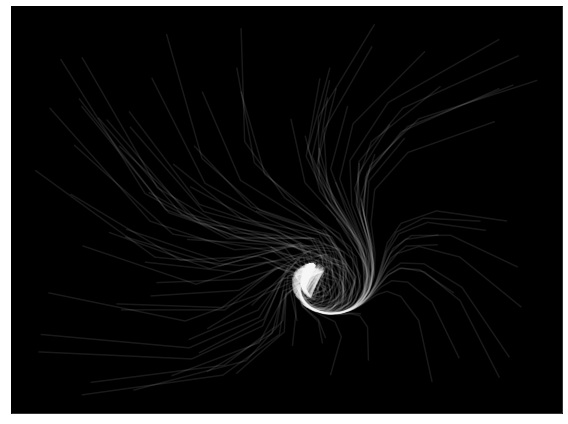

In [41]:
ikeda(.6, 10**2, 2*10**2)

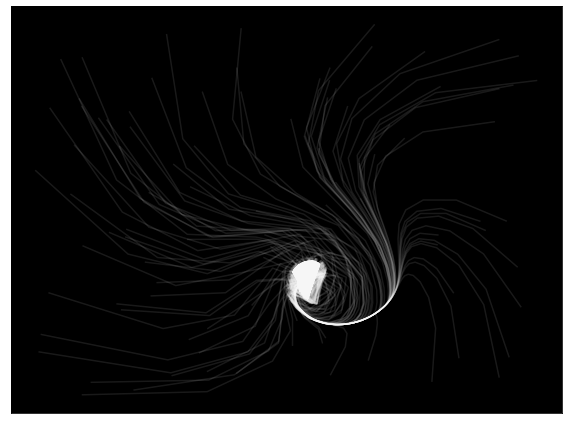

In [40]:
ikeda(.7, 10**2, 2*10**2)

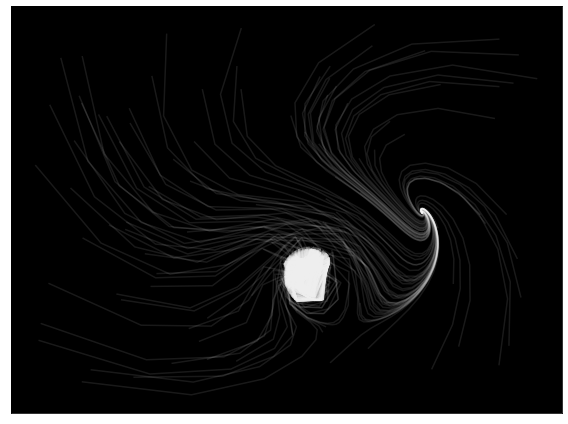

In [42]:
ikeda(.8, 10**2, 2*10**2)

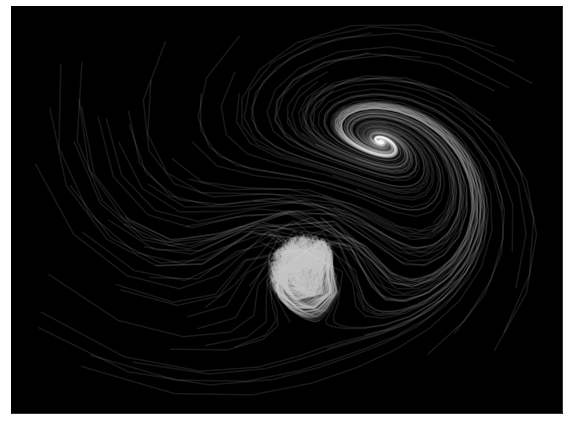

In [43]:
ikeda(.9, 10**2, 2*10**2)

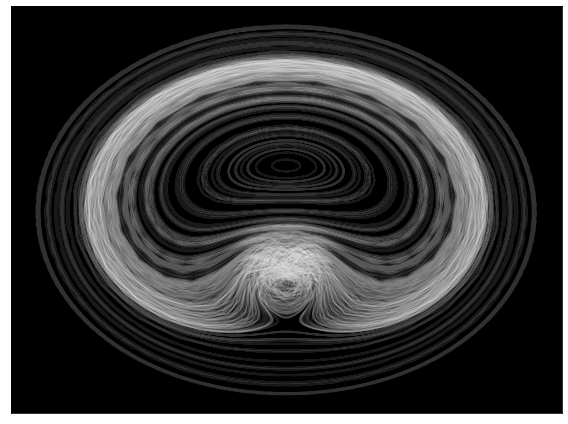

In [44]:
ikeda(1, 10**2, 2*10**2)

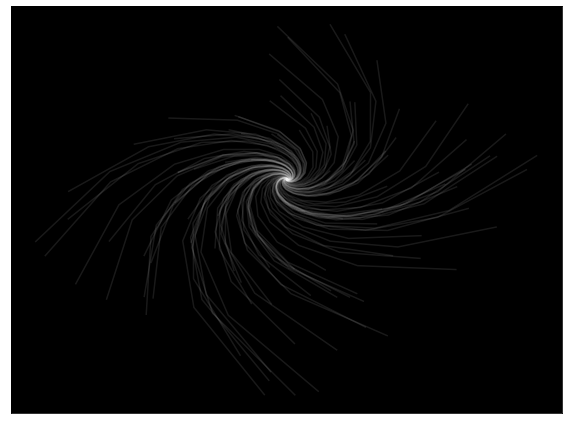

In [45]:
ikeda(1.5, 10**2, 2*10**2)

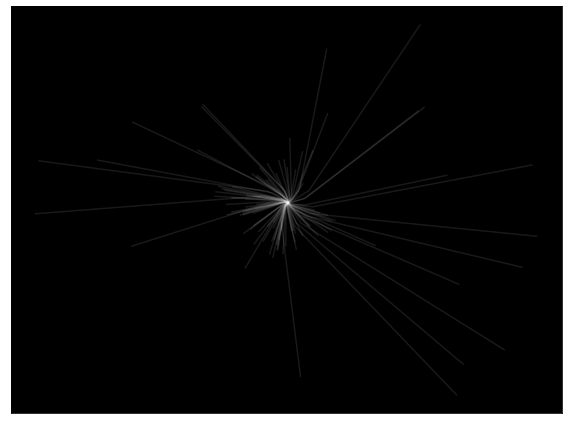

In [47]:
ikeda(10, 10**2, 2*10**2)

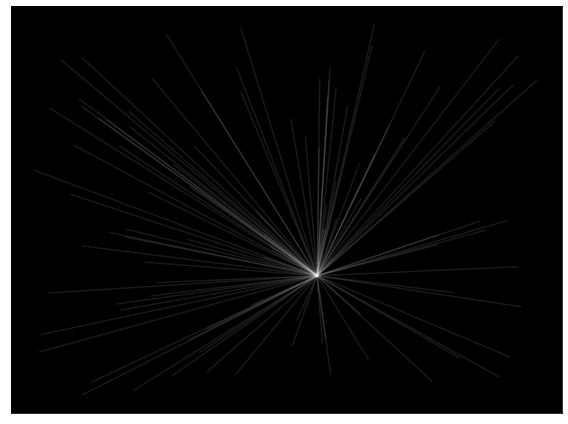

In [49]:
ikeda(0, 10**2, 2*10**2)